###### Project: NLP Entity Linking
###### Step: Extracting and Summarizing Key Terms
###### Author: Fabio C. Souza - Jun/2022

In [10]:
# Imports

import io
import requests
import pathlib
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# The code was removed by Watson Studio for sharing.

In [12]:
# Storage access object

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

sto = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=ibm_api_key_id,
    ibm_auth_endpoint=ibm_auth_endpoint,
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_url)

In [13]:
# Import Dabater

key = 'debater_python_api.zip'
sto.download_file(Bucket=bucket, Key=key, Filename=key)
with zipfile.ZipFile(key, 'r') as zf:
    zf.extractall()
    
from debater_python_api.api.debater_api import DebaterApi

In [14]:
# 1-Loading the API key and create a client for the Term Wikifier service

debater_api = DebaterApi(apikey=api_key)
term_wikifier_client = debater_api.get_term_wikifier_client()
arg_quality_client = debater_api.get_argument_quality_client()
keypoints_client = debater_api.get_keypoints_client()

In [15]:
# 2-Reloading the DataFrame from Milestone 2 

key = "df_merge.csv"
sto.download_file(Bucket=bucket, Key=key, Filename=key)
df_merge = pd.read_csv(key)

In [16]:
# 3-Defining a function that uses the Term Wikifier service to map from a given medical transcription in our input dataset to a set of mentions in Wikipedia

def get_sentence_to_mentions (sentences_texts):
    mentions_list = term_wikifier_client.run(sentences_texts)
    sentence_to_mentions = {}

    for sentence_text, mentions in zip(sentences_texts, mentions_list):
        sentence_to_mentions[sentence_text] = set([
            mention["concept"]["title"]
            for mention in mentions
        ])
    
    return sentence_to_mentions

In [8]:
#FCS: Checking values
for kp in set(df_merge["kp"].values):
    print('***' +kp+'***')
    print(df_merge["sentence_text"][df_merge["kp"] == kp].values)

*** Routine colorectal cancer screening***
[' Routine colorectal cancer screening'
 ' Bladder lesions with history of previous transitional cell bladder carcinoma, pathology pending.'
 ' Whole body radionuclide bone scan due to prostate cancer.'
 ' She has had colonoscopies required every five years and every time she has polyps were found'
 ' The patient is a 62-year-old white male who presents to the office with a history of colon polyps and need for recheck.'
 ' She was referred for a screening colonoscopy'
 ' Squamous cell carcinoma of right temporal bone/middle ear space'
 ' A coloscopy is now being performed for completion.'
 ' Laparoscopic cholecystectomy with cholangiogram'
 " The patient underwent corporal aspiration and Winter's shunt both of which failed"
 'She had a recent D&C and laparoscopy, and enlarged mass was noted and could not be determined if it was from the ovary or the uterus'
 ' The patient is a 52-year-old male who is here for independent medical evaluation.']


In [9]:
#FCS Test
# Just one KPA and Term Wikifier

domain = "Just a random test"
keypoints_client.delete_domain_cannot_be_undone(domain)

comments = ["Between citrus fruits, oranges and lemons are the ones most used to do delicious juices.",
            "Citrus fruits are, at the same time, popular and very healthy, containing lots of C vitamin.",
            "The C vitamin is very important to the organism so it can produce anti-oxidants and be prevented against scorbutic disease.",
            "The C vitamin fortifies the body against flu and colds.",
            "There are several kinds of oranges."]

"""
keypoints_client.upload_comments(
    domain=domain,
    comments_ids=[str(x) for x in range(5)],
    comments_texts=comments,
    dont_split=False,
)

keypoints_client.wait_till_all_comments_are_processed(domain=domain)

run_params = {
    "mapping_threshold": .90,
    "n_top_kps": 10,
}

future = keypoints_client.start_kp_analysis_job(
    domain=domain,
    comments_ids=["1"],
    run_params=run_params,
)

kpa_result = future.get_result(
    high_verbosity=False,
    polling_timout_secs=5,
)

future.get_job_id();

lst_kpa = []
for i in range(len(kpa_result.get('keypoint_matchings'))):
    for j in range(len(kpa_result.get('keypoint_matchings')[i])):
        kp = kpa_result.get('keypoint_matchings')[i].get('keypoint')
        for k in range(len(kpa_result.get('keypoint_matchings')[i].get('matching'))):
            comment_id = kpa_result.get('keypoint_matchings')[i].get('matching')[k].get('comment_id')
            lst_kpa.append([kp, comment_id])
            
print('kpas', lst_kpa)"""

t="Joseph-Louis Lagrange[a] (born Giuseppe Luigi Lagrangia[5][b] or Giuseppe Ludovico De la Grange Tournier;[6][c] 25 January 1736 – 10 April 1813), "
t=t+"also reported as Giuseppe Luigi Lagrange[7] or Lagrangia,[8] was an Italian mathematician and astronomer, later naturalized French. "
t=t+"He made significant contributions to the fields of analysis, number theory, and both classical and celestial mechanics."
get_sentence_to_mentions([t])

TermWikifierClient: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


{'Joseph-Louis Lagrange[a] (born Giuseppe Luigi Lagrangia[5][b] or Giuseppe Ludovico De la Grange Tournier;[6][c] 25 January 1736 – 10 April 1813), also reported as Giuseppe Luigi Lagrange[7] or Lagrangia,[8] was an Italian mathematician and astronomer, later naturalized French. He made significant contributions to the fields of analysis, number theory, and both classical and celestial mechanics.': {'Analysis',
  'Astronomer',
  'Celestial mechanics',
  'Field (mathematics)',
  'Fundraising',
  'Giuseppe',
  'Joseph-Louis Lagrange',
  'Luigi',
  'Naturalization',
  'Number theory'}}

In [17]:
# 4-Using this function to tally the references in Wikipedia for each identified key point from our analysis in Milestone 2

from collections import Counter

terms = {}

for kp in set(df_merge["kp"].values):
    sentence_to_mentions = get_sentence_to_mentions(
        df_merge["sentence_text"][df_merge["kp"] == kp].values
    )
    
    all_mentions = [
        mention
        for sentence in sentence_to_mentions
        for mention in sentence_to_mentions[sentence]
    ]

    term_count = dict(Counter(all_mentions))
    
    if "History" in term_count.keys():
        term_count.pop("History")
   
    terms[kp] = term_count

TermWikifierClient: 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]


In [20]:
# FCS: qual são as estruturas das variáveis (da última iteração acima)

sentence_to_mentions

{' Hematemesis in a patient with longstanding diabetes': {'Diabetes',
  'Hematemesis',
  'Patient'},
 ' The patient is developing gestational diabetes.': {'Gestational diabetes',
  'Patient'},
 ' A female with a history of severe dysmenorrhea and menorrhagia unimproved with medical management.': {'Dysmenorrhea',
  'Female',
  'Health administration',
  'Heavy menstrual bleeding',
  'History',
  'Road surface'},
 ' EMG/Nerve Conduction Study showing sensory motor length-dependent neuropathy consistent with diabetes, severe left ulnar neuropathy, and moderate-to-severe left median neuropathy, ': {'Consistency',
  'Diabetes',
  'Electromyography',
  'Engine',
  'Median nerve',
  'Nerve conduction study',
  'Peripheral neuropathy',
  'Sensory neuron',
  'Ulnar neuropathy'},
 ' The patient is being referred for evaluation of diabetic retinopathy.': {'Diabetic retinopathy',
  'Evaluation',
  'Patient'},
 ' An 83-year-old diabetic female presents today stating that she would like diabetic foo

In [22]:
term_count

{'Hematemesis': 1,
 'Diabetes': 3,
 'Patient': 4,
 'Gestational diabetes': 1,
 'Female': 2,
 'Health administration': 1,
 'Heavy menstrual bleeding': 1,
 'Dysmenorrhea': 1,
 'Road surface': 1,
 'Sensory neuron': 1,
 'Consistency': 1,
 'Engine': 1,
 'Electromyography': 1,
 'Ulnar neuropathy': 1,
 'Peripheral neuropathy': 1,
 'Nerve conduction study': 1,
 'Median nerve': 1,
 'Evaluation': 1,
 'Diabetic retinopathy': 1,
 'Diabetic foot': 1,
 'Obesity': 1,
 'Polychronion': 1,
 'Weight loss': 1}

In [23]:
terms

{' Sepsis due to urinary tract infection.': {'Sepsis': 2,
  'Urinary tract infection': 2,
  'Otitis media': 1,
  'Fever': 2,
  'Bloodstream infections': 1,
  'Elevated railway': 1,
  'Patient': 2,
  'Thoracic wall': 1,
  'Methicillin-resistant Staphylococcus aureus': 1,
  'Relapse': 1,
  'Escherichia coli': 1},
 ' Possible inflammatory bowel disease': {'Inflammatory bowel disease': 3,
  'Diabetes': 2,
  'Hypertension': 3,
  'Insomnia': 1,
  'Irritable bowel syndrome': 1,
  'Hiatal hernia': 3,
  'Gastroesophageal reflux disease': 3,
  'Sepsis': 2,
  'Diagnosis': 2,
  'Kidney failure': 2,
  'Pancreatitis': 1,
  'Respiratory system': 2,
  'Patient': 23,
  'Hypotension': 1,
  'Constipation': 1,
  'Colonoscopy': 1,
  'Abnormality (behavior)': 2,
  'CT scan': 6,
  'Rectal bleeding': 3,
  'Pelvic pain': 5,
  'Enterocele': 1,
  'Pelvis': 7,
  'Adhesion': 5,
  'Chronic condition': 10,
  'Uterus': 2,
  'Pelvic inflammatory disease': 3,
  'Uterine fibroid': 3,
  'Nausea': 8,
  'Diarrhea': 3,
  'F

In [24]:
# 5-Displaying the analysis for one diagnosis to see the structure of its annotations

df_check = pd.DataFrame(
    list(terms[" Microinvasive carcinoma of the cervix."].items()),
    columns = ["Term", "Count"],
).sort_values(by="Count", ascending=False)

df_check.head(10)

,Term,Count
22,Patient,4
14,Biopsy,3
49,Subdural hematoma,2
11,Laparoscopy,2
37,Bladder cancer,2
12,Cholecystectomy,2
33,Cystoscopy,2
56,Caudate nucleus,1
45,Cell biology,1
35,Size,1


In [25]:
# Adding terms from wikifier

print(df_merge.shape)
df_merge['Term'] = df_merge['sentence_text'].apply(lambda x:sentence_to_mentions.get(x))
print(df_merge.shape)

(892, 13)
(892, 14)


In [36]:
# Um dicionário de termos para cada sentença

df_merge[df_merge['Term'].apply(lambda x: True if x is not None else False)]

,kp,sentence_text,match_score,comment_id,sentence_id,sents_in_comment,span_start,span_end,num_tokens,argument_quality,id,id_description,medical_specialty_new,Term
863,Hematemesis in a patient with longstanding di...,Hematemesis in a patient with longstanding di...,1.000000,1528,0,1,0,52,7,0.646402,1528,1278,Gastroenterology,"{Hematemesis, Diabetes, Patient}"
864,Hematemesis in a patient with longstanding di...,The patient is developing gestational diabetes.,0.999720,279,0,1,0,48,6,0.654647,279,364,Radiology,"{Gestational diabetes, Patient}"
865,Hematemesis in a patient with longstanding di...,A female with a history of severe dysmenorrhe...,0.999693,1455,0,1,0,99,14,0.675275,1455,1236,Obstetrics / Gynecology,"{Female, History, Health administration, Heavy..."
866,Hematemesis in a patient with longstanding di...,EMG/Nerve Conduction Study showing sensory mo...,0.998472,919,0,1,0,181,24,0.707252,919,917,Radiology,"{Sensory neuron, Consistency, Engine, Electrom..."
867,Hematemesis in a patient with longstanding di...,The patient is being referred for evaluation ...,0.993360,3240,0,1,0,70,10,0.651706,3240,2353,Ophthalmology,"{Evaluation, Diabetic retinopathy, Patient}"
868,Hematemesis in a patient with longstanding di...,An 83-year-old diabetic female presents today...,0.986231,2980,0,1,0,94,16,0.429527,2980,2154,Surgery,"{Diabetes, Female, Diabetic foot}"
869,Hematemesis in a patient with longstanding di...,Patient suffered from morbid obesity for many...,0.982016,46,0,1,0,122,18,0.595291,46,37,Bariatrics,"{Obesity, Polychronion, Weight loss, Patient}"


In [37]:
df_merge[df_merge["sentence_text"].apply(lambda x: x.find("CO2 insufflation was done")>-1)]

,kp,sentence_text,match_score,comment_id,sentence_id,sents_in_comment,span_start,span_end,num_tokens,argument_quality,id,id_description,medical_specialty_new,Term
2,none,CO2 insufflation was done to a maximum press...,0.0,1591,0,1,0,121,22,0.492457,1591,1304,Gastroenterology,None


In [38]:
df_merge[df_merge["kp"] == "none"]

,kp,sentence_text,match_score,comment_id,sentence_id,sents_in_comment,span_start,span_end,num_tokens,argument_quality,id,id_description,medical_specialty_new,Term
0,none,The patient is a 1-year-old male with a his...,0.0,1220,0,1,0,157,26,0.650918,1220,1114,Pediatrics - Neonatal,None
1,none,"At the time of discharge, the patient had im...",0.0,577,0,1,0,53,9,0.442226,577,595,General Medicine,None
2,none,CO2 insufflation was done to a maximum press...,0.0,1591,0,1,0,121,22,0.492457,1591,1304,Gastroenterology,None
3,none,"Intrauterine pregnancy of 39 weeks, Herpes s...",0.0,1302,0,1,0,257,34,0.630517,1302,1160,Obstetrics / Gynecology,None
4,none,"L1 laminotomy, microdissection, retrieval of...",0.0,1100,0,1,0,161,20,0.588591,1100,1036,Neurosurgery,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,none,"Well developed, well nourished, in no acute d...",0.0,994,0,1,0,54,8,0.635106,994,967,General Medicine,None
338,none,"When the endarterectomy was performed, the ex...",0.0,2241,0,1,0,84,12,0.480896,2241,1626,Cardiovascular / Pulmonary,None
339,none,A standard curvilinear umbilical incision was ...,0.0,2599,0,1,0,169,25,0.508166,2599,1830,Urology,None
340,none,The patient is having recurrent attacks of ver...,0.0,75,0,1,0,168,27,0.759615,75,77,ENT - Otolaryngology,None


In [40]:
# 6-Removing any rows that have a key point "none", then compare the relative size of each key point cluster

print(df_merge.shape)
df_clean = df_merge[df_merge["kp"] != "none"]
print(df_clean.shape)
df_clean["kp"].value_counts()

(892, 14)
(550, 14)


 Possible inflammatory bowel disease                              128
 Lumbar muscle strain and chronic back pain                       106
 Risk factors for coronary heart disease.                          75
 Hemoptysis and history of lung cancer                             44
 Enlarged fibroid uterus, hypermenorrhea, and secondary anemia     31
 No evidence of polyps or malignancy.                              30
 Unilateral transpedicular T11 vertebroplasty.                     26
 Microinvasive carcinoma of the cervix.                            19
 Cerebral palsy, worsening seizures                                14
 Routine colorectal cancer screening                               12
 No complications were encountered throughout the procedure.       10
 Cognitive linguistic impairment secondary to stroke                9
 Congestive heart failure, stable on current regimen                9
 Palpitations, possibly related to anxiety                          8
 Hematemesis in a pa

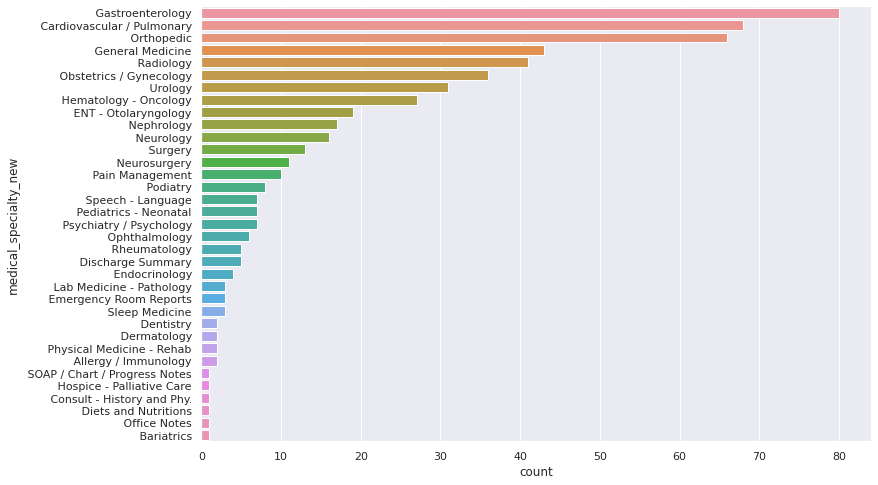

In [41]:
# 7-Developing content for a dashboard and rendering bar charts using seaborn and Matplotlib

sns.set(rc = { "figure.figsize": (12, 8) })
sns.countplot(
    y="medical_specialty_new",
    data=df_clean,
    order=df_clean["medical_specialty_new"].value_counts().index
);

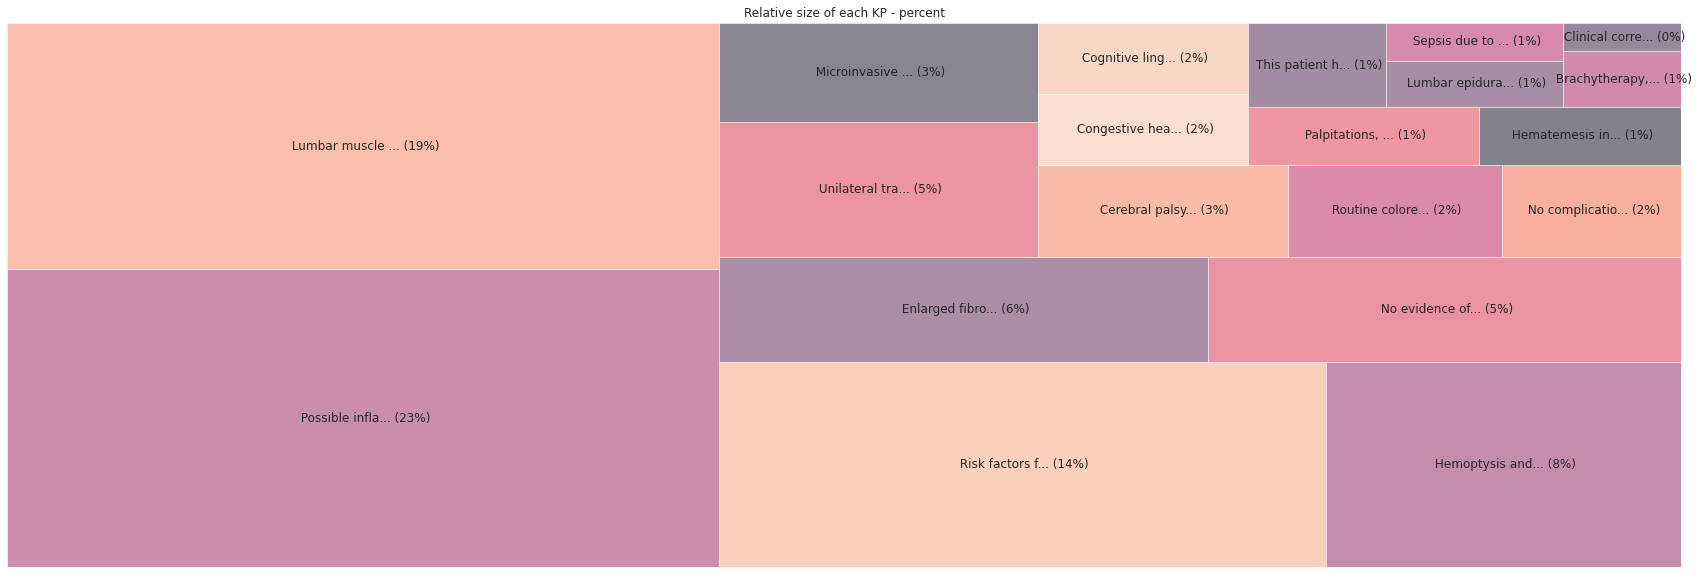

In [42]:
# display a comparison of the relative size of each key point cluster (prepare for step4)

# libraries
!pip install squarify
import matplotlib.pyplot as plt
import squarify

# prepare auxiliary dataframe to be plotted - cutting to long kp names to fit into each box
df_clean_relat_sz = df_clean.groupby(by='kp').agg({'comment_id':'count'}).reset_index()
df_clean_relat_sz['total_comments'] = df_clean_relat_sz['comment_id'].sum()
df_clean_relat_sz['relative_size'] = (df_clean_relat_sz['comment_id'] / df_clean_relat_sz['total_comments']) *100
df_clean_relat_sz.sort_values(by='relative_size', ascending=False, inplace=True)
df_clean_relat_sz['kp_short'] = df_clean_relat_sz['kp'].apply(lambda x: x[:15] + "...")
df_clean_relat_sz['kp_short'] = df_clean_relat_sz[['kp_short','relative_size']].\
                                            apply(lambda r: r['kp_short'] + " (" + str(int(round(r['relative_size'],0))) + "%)", axis=1) 

# plot relative size - treemap
fig = plt.figure(figsize=(30,10))
squarify.plot(sizes=df_clean_relat_sz['relative_size'], label=df_clean_relat_sz['kp_short'], alpha=.5 )
plt.axis('off')
plt.title('Relative size of each KP - percent')
plt.show()

In [43]:
# 8-Saving the DataFrame to a file named df_clean.csv for use later

key = "df_clean.csv"
df_clean.to_csv(key, index=False)
sto.upload_file(Bucket=bucket, Key=key, Filename=key)

In [44]:
print('ok')

ok
